# KM2

Poniższy kamień milowy przedstawia inżynierię danych oraz wstępne modelowanie dla danych "gender_voice_dataset.csv", które przedstawiają dane statystyczne nagrań głosowych różnych ludzi. Zadaniem jest klasyfikacja kolumny 'label', która przedstawia płeć osoby mówiącej.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Data upload and basic transforms

In [2]:
%precision %.6f
data = pd.read_csv("gender_voice_dataset.csv")
LB = LabelBinarizer()
data["label"] = LB.fit_transform(data["label"])
y = np.array(data["label"])
X = data.drop(['label'],axis=1)
X.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx'],
      dtype='object')

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
print(len(X))
X.head()

3168


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


In [5]:
y

array([1, 1, 1, ..., 0, 0, 0])

1 to mężyczyzni, 0 to kobiety.

## Feature Engineering

Najpierw sprawdzamy prosty klasyfikator na już posiadanych cechach, by znaleźć numeryczną "ważność" cech.

In [6]:
def split(X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.3, random_state=42)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def plot_features(X_plot, importances_plot, indices_plot, std_plot):
  plt.figure(figsize=(16,16))
  plt.title("Feature importances")
  plt.bar(range(X_plot.shape[1]), importances_plot[indices_plot],
          color="r", yerr=std_plot[indices_plot], align="center")
  plt.xticks(range(X_plot.shape[1]), indices_plot)
  plt.xlim([-1, X_plot.shape[1]])
  plt.show()
  return

In [8]:
def feature_importance(X_prim, y_prim):
  X_train, X_val, X_test, y_train, y_val, y_test = split(X_prim, y_prim)
  forest = RandomForestClassifier(n_estimators=100, random_state=3, max_depth=5)
  forest.fit(X_train, y_train)
  print(f"Forest score: {forest.score(X_val, y_val)}")
  importances = forest.feature_importances_
  std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")
  z = []
  for f in range(X_prim.shape[1]):
      z.append(X_prim.columns[indices[f]])
      print(f"{f}. Feature: {X_prim.columns[indices[f]]} ({importances[indices[f]]})" )
  print("Features in order of decreasing importance:")
  print(z)
  plot_features(X_prim, importances, indices, std)
  return

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)

Forest score: 0.976775956284153
Feature ranking:
0. Feature: meanfun (0.3730480606041995)
1. Feature: IQR (0.18068260670112893)
2. Feature: Q25 (0.1654106623519519)
3. Feature: sd (0.10138369560814825)
4. Feature: sp.ent (0.03764084212078971)
5. Feature: sfm (0.024211412677322453)
6. Feature: centroid (0.01925311587804616)
7. Feature: mode (0.017082554571492412)
8. Feature: meanfreq (0.014620150930463418)
9. Feature: mindom (0.009127135173735814)
10. Feature: median (0.008139557390557285)
11. Feature: maxdom (0.007797658429642278)
12. Feature: skew (0.007142328092043546)
13. Feature: Q75 (0.006881542475392338)
14. Feature: kurt (0.00625604272119457)
15. Feature: minfun (0.0059435120337111205)
16. Feature: dfrange (0.005569110241437829)
17. Feature: meandom (0.004914936254316448)
18. Feature: maxfun (0.002564453405151461)
19. Feature: modindx (0.0023306223392745877)
Features in order of decreasing importance:
['meanfun', 'IQR', 'Q25', 'sd', 'sp.ent', 'sfm', 'centroid', 'mode', 'meanfreq

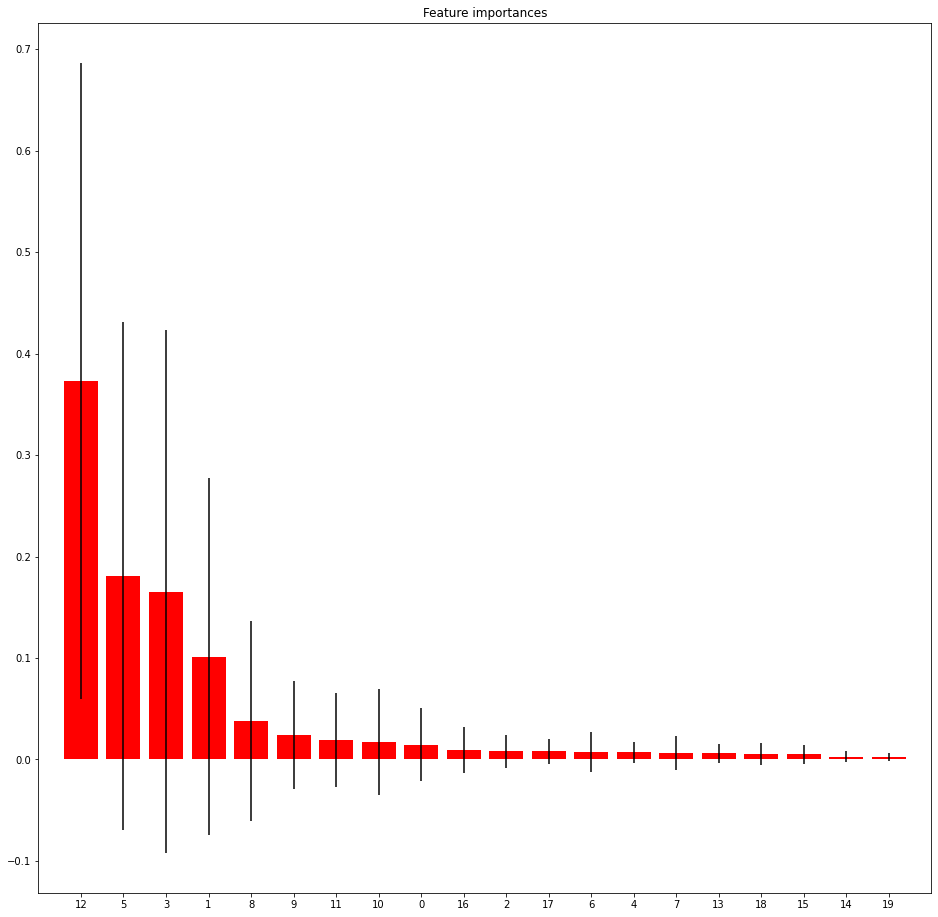

In [10]:
feature_importance(X, y)

Teraz sprawdzamy rozszerzając dane o wymnożenia wszystkich kombinacji dwóch cech. (Polynomial features)

Forest score: 0.9808743169398907
Feature ranking:
0. Feature: meanfun^2 (0.11206663528082693)
1. Feature: meanfun (0.08173151241406311)
2. Feature: sp.ent meanfun (0.07870896943321555)
3. Feature: meanfreq IQR (0.05784046327309138)
4. Feature: meanfun maxfun (0.052545351744354596)
5. Feature: IQR^2 (0.04033255748737141)
6. Feature: Q75 IQR (0.03764606423774803)
7. Feature: IQR (0.03685819983725974)
8. Feature: Q25 meanfun (0.035103655791838675)
9. Feature: IQR sp.ent (0.03489305955044352)
10. Feature: sd IQR (0.033578007721619424)
11. Feature: median IQR (0.026553387010480812)
12. Feature: sd meanfun (0.023318836647589797)
13. Feature: Q25^2 (0.021162297288636053)
14. Feature: meanfreq Q25 (0.020744521575336145)
15. Feature: IQR centroid (0.02029828752135873)
16. Feature: centroid meanfun (0.01792774321739263)
17. Feature: sd Q75 (0.015738668482412364)
18. Feature: sfm meanfun (0.015730877945356905)
19. Feature: IQR maxfun (0.014567079162893414)
20. Feature: IQR sfm (0.0145472103210333

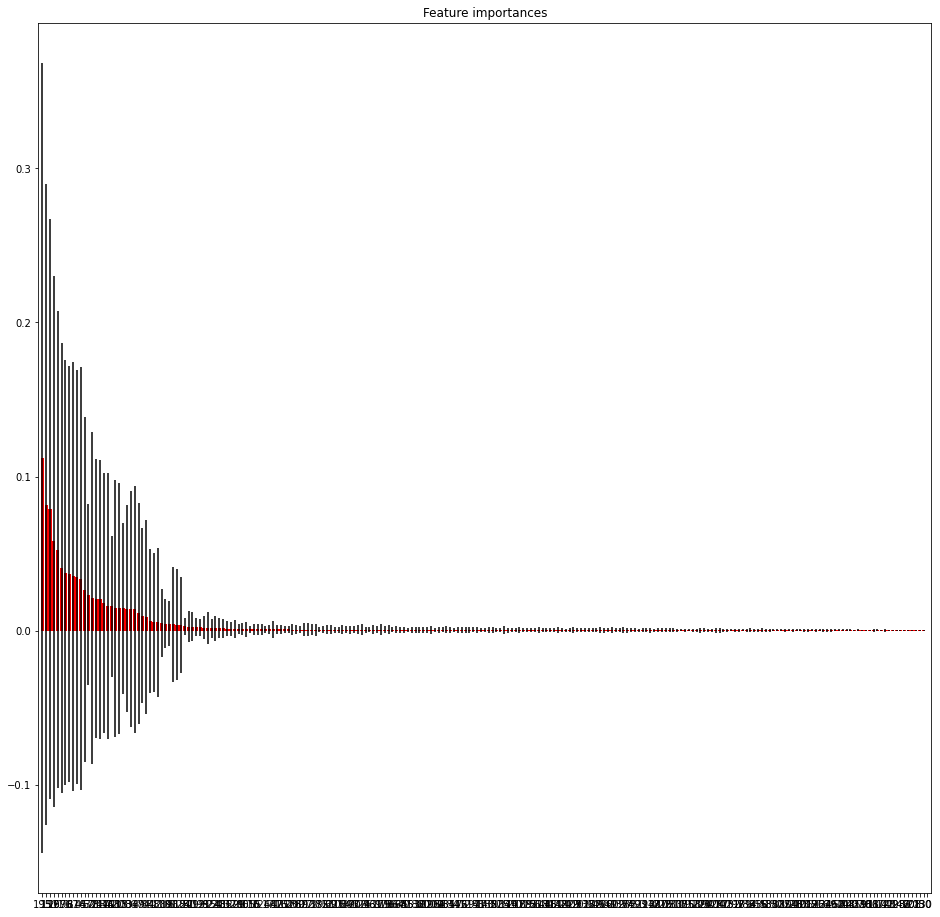

In [11]:
poly = PolynomialFeatures(degree=2)
X2 = poly.fit_transform(X)
X2 = pd.DataFrame(X2, columns = poly.get_feature_names(X.columns))

feature_importance(X2, y)

Tutaj sprawdzaliśmy jakie rezultaty uzyskamy po odrzuceniu konkretnych zestawów kolumn. Zestawy tworzyliśmy na podstawie wcześniejszej analizy ważności cech. Finalny zestaw kolumn jeszcze do sprecyzowania.

In [12]:
drops = ['meanfreq', 'mindom', 'median', 'maxdom', 'skew', 'Q75', 'kurt', 'minfun', 'dfrange', 'meandom', 'maxfun', 'modindx']
#Columns in importance order
#drops = ['meanfun', 'IQR', 'Q25', 'sd', 'sp.ent', 'sfm', 'centroid', 'mode', 'meanfreq', 'mindom', 'median', 'maxdom', 'skew', 'Q75', 'kurt', 'minfun', 'dfrange', 'meandom', 'maxfun', 'modindx']
#['meanfun^2', 'meanfun', 'sp.ent meanfun', 'meanfreq IQR', 'meanfun maxfun', 'IQR^2', 'Q75 IQR', 'IQR', 'Q25 meanfun', 'IQR sp.ent', 'sd IQR', 'median IQR', 'sd meanfun', 'Q25^2', 'meanfreq Q25', 'IQR centroid', 'centroid meanfun', 'sd Q75', 'sfm meanfun', 'IQR maxfun', 'IQR sfm', 'Q75 meanfun', 'meanfreq meanfun', 'Q25 centroid', 'Q25', 'Q25 maxfun', 'median meanfun', 'Q25 sp.ent', 'sd^2', 'sd sp.ent', 'sd', 'IQR meanfun', 'Q25 IQR', 'meanfun minfun', 'median Q25', 'IQR skew', 'IQR modindx', 'Q25 sfm', 'Q25 skew', 'Q25 Q75', 'IQR minfun', 'meanfun mindom', 'meanfreq^2', 'Q25 kurt', 'meanfreq sd', 'sd maxfun', 'sd Q25', 'centroid^2', 'skew meanfun', 'IQR mindom', 'sfm maxfun', 'Q75 sp.ent', 'Q25 meandom', 'sfm^2', 'IQR mode', 'sfm', 'Q75', 'IQR dfrange', 'meanfreq', 'median sp.ent', 'median minfun', 'sd median', 'sfm modindx', 'sp.ent maxdom', 'IQR maxdom', 'mode^2', 'Q75 sfm', 'median sfm', 'Q25 mindom', 'Q25 maxdom', 'median maxfun', 'meanfreq maxdom', 'sfm mindom', 'Q75^2', 'mode', 'median centroid', 'mindom^2', 'Q75 maxdom', 'sp.ent sfm', 'skew modindx', 'centroid dfrange', 'median modindx', 'minfun mindom', 'skew sfm', 'meanfreq Q75', 'sd skew', 'skew centroid', 'sp.ent', 'mode minfun', 'mode meanfun', 'sp.ent centroid', 'sfm minfun', 'sfm centroid', 'median mode', 'meanfreq modindx', 'sd meandom', 'sp.ent^2', 'centroid minfun', 'meanfreq sfm', 'IQR meandom', 'meanfun maxdom', 'meanfun meandom', 'meanfun modindx', 'median skew', 'Q25 dfrange', 'sp.ent modindx', 'mode dfrange', 'sd centroid', 'kurt meanfun', 'median dfrange', 'centroid', 'maxfun dfrange', 'Q75 skew', 'sd minfun', 'mindom', 'kurt^2', 'mode modindx', 'meanfreq dfrange', 'meanfreq mode', 'maxdom^2', 'meanfreq minfun', 'skew meandom', 'minfun', 'meandom mindom', 'Q75 mode', 'centroid maxfun', 'sfm maxdom', 'Q25 mode', 'sd mindom', 'maxfun maxdom', 'kurt centroid', 'mode meandom', 'Q25 minfun', 'sp.ent mindom', 'kurt sfm', 'mindom modindx', 'mode mindom', 'meandom dfrange', 'Q75 dfrange', 'skew', 'meanfun dfrange', 'skew mindom', 'meanfreq skew', 'skew maxdom', 'kurt minfun', 'centroid meandom', 'meandom modindx', 'kurt mindom', 'median Q75', 'minfun modindx', 'skew minfun', 'meanfreq kurt', 'median mindom', 'median maxdom', 'sd modindx', 'dfrange modindx', 'median', 'IQR kurt', 'meandom maxdom', 'sd kurt', 'maxdom modindx', 'mindom maxdom', 'Q75 maxfun', 'kurt dfrange', 'mode maxfun', 'maxfun meandom', 'meanfreq mindom', 'sp.ent mode', 'centroid mindom', 'sp.ent minfun', 'mode centroid', 'mindom dfrange', 'centroid modindx', 'maxfun mindom', 'Q75 mindom', 'minfun maxfun', 'kurt', 'Q75 centroid', 'median meandom', 'kurt modindx', 'centroid maxdom', 'meandom', 'sfm meandom', 'mode maxdom', 'Q25 modindx', 'median kurt', 'maxfun modindx', 'meanfreq meandom', 'sd dfrange', 'skew dfrange', 'kurt maxdom', 'sd mode', 'skew kurt', 'meanfreq maxfun', 'Q75 minfun', 'dfrange^2', 'maxfun^2', 'sp.ent dfrange', 'Q75 meandom', 'minfun meandom', 'dfrange', 'skew^2', 'meandom^2', 'skew maxfun', 'maxdom dfrange', 'sd sfm', 'sp.ent meandom', 'sd maxdom', 'modindx', 'kurt meandom', 'kurt mode', 'minfun maxdom', 'sp.ent maxfun', 'modindx^2', 'Q75 kurt', 'sfm mode', 'maxdom', 'Q75 modindx', 'sfm dfrange', 'kurt sp.ent', 'meanfreq median', 'meanfreq sp.ent', 'skew sp.ent', 'kurt maxfun', 'meanfreq centroid', 'median^2', 'minfun dfrange', 'minfun^2', 'maxfun', 'skew mode', '1']

#X = X2[['sp.ent', 'meanfreq IQR', 'meanfun maxfun', 'IQR', 'sd',]]
#X = X2[['meanfun^2', 'sp.ent', 'meanfreq IQR', 'meanfun maxfun', 'IQR sp.ent', 'sd']]
X = X.drop(drops, axis=1)
X.columns

Index(['sd', 'Q25', 'IQR', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun'], dtype='object')

Tutaj testowaliśmy lasy z innymi hiperparametrami.

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)

In [14]:
forest2 = RandomForestClassifier(n_estimators=100, random_state=10, max_depth=6)
forest2.fit(X_train, y_train)
print(forest2.score(X_val, y_val))

0.9808743169398907


In [15]:
X_train, X_val, X_test, y_train, y_val, y_test = split(X, y)

In [16]:
forest = RandomForestClassifier(n_estimators=5, random_state=10)
forest.fit(X_train, y_train)
print("Validation score: {:.6f}".format(forest.score(X_val, y_val)))
print("Test score: {:.6f}".format(forest.score(X_test,y_test)))

Validation score: 0.979508
Test score: 0.987261


Teraz sprawdzaliśmy jaki wynik mają podstawowe modele w różnych metrykach.

In [17]:
lr = LogisticRegression(max_iter=1000)
tree = DecisionTreeClassifier()
SVM = SVC(kernel='linear', C=1.0)
nb = GaussianNB()
forest1 = RandomForestClassifier(n_estimators=100, random_state=10, max_depth=6)
forest2 = RandomForestClassifier(n_estimators=5, random_state=10)
estimators = [('Logistic Regression', lr), ('Decision Tree', tree), ('SVM', SVM), ('Naive Bayes', nb), ('Random Forest 1', forest1), ('Random Forest 2', forest2)]
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
matrix = []
for name, model in estimators:
    row = [name]
    for score in scoring:
        result = cross_val_score(model, X, y, cv=5, scoring=score).mean()
        row.append(result)
    matrix.append(row)
result = pd.DataFrame(matrix, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "Roc-Auc"])

In [18]:
result

,Model,Accuracy,Precision,Recall,F1,Roc-Auc
0,Logistic Regression,0.903435,0.862941,0.971601,0.912226,0.941155
1,Decision Tree,0.956760,0.954945,0.953927,0.952598,0.955503
2,SVM,0.916055,0.875755,0.978549,0.922897,0.970967
3,Naive Bayes,0.929612,0.909160,0.960236,0.932718,0.979323
4,Random Forest 1,0.965279,0.963386,0.967813,0.965344,0.993128
5,Random Forest 2,0.963700,0.963939,0.964028,0.963635,0.985301


W powyższej tabelce zauważamy, że wyniki są bardzo obiecujące. Widać, że najlepsze rezultaty osiąga RandomForest, jednak musi być jeszcze przeprowadzona analiza dla różnych hiperparametrów przed wyborem finalnego modelu.

Poniżej wygenerowaliśmy rysunek reprezentujący jakie cechy bierze pod uwagę losowe drzewo decyzyjne.

Accuracy score: 0.9713375796178344


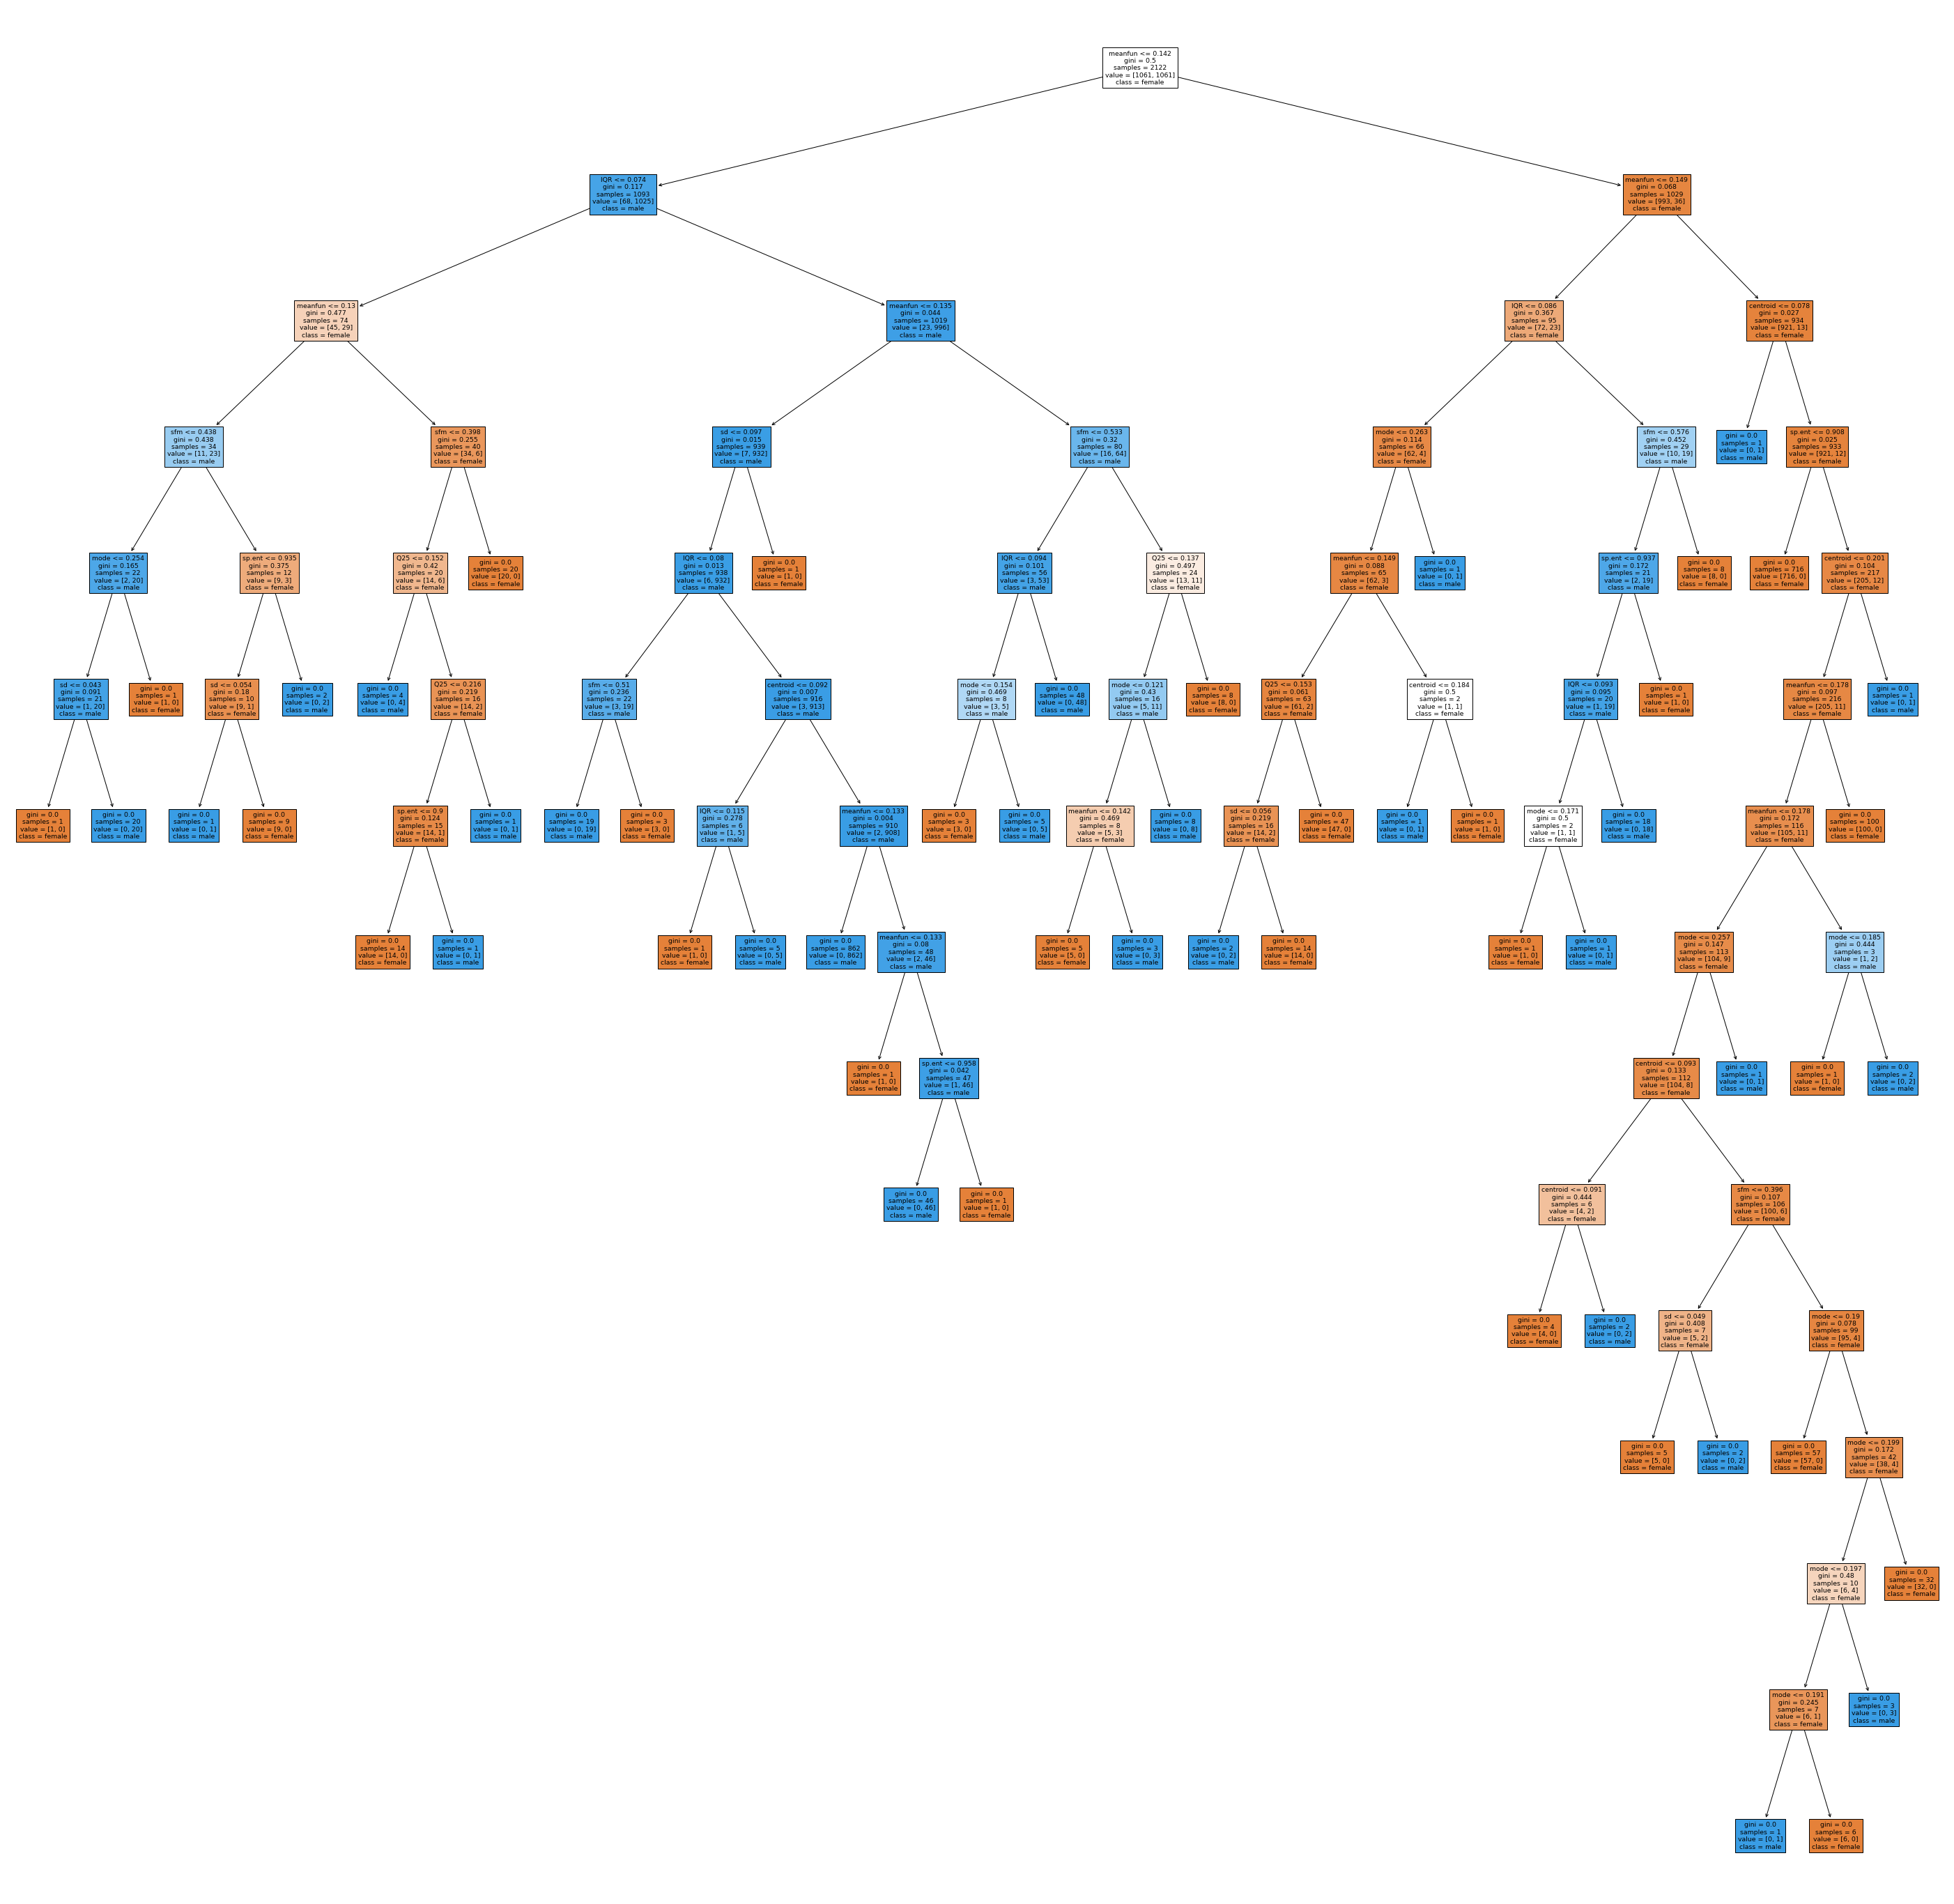

In [19]:
tree2 = DecisionTreeClassifier()
tree2.fit(X_train, y_train)
print(f"Accuracy score: {tree2.score(X_test, y_test)}")
plt.figure(figsize=(50,50))
splits=plot_tree(tree2, feature_names=X.columns, class_names=['female', 'male'], filled=True)

In [20]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
